# Demo: Applying Quality Control.
In this example, we apply Quality Control (QC) on the demo data. 

In [1]:
import metobs_toolkit


## Create your dataset
We start by creating a dataset.

In [2]:

# Create the dataset and import data using the demo files
dataset = metobs_toolkit.Dataset()
dataset.import_data_from_file(
    template_file=metobs_toolkit.demo_template,
    input_data_file=metobs_toolkit.demo_datafile,
    input_metadata_file=metobs_toolkit.demo_metadatafile,
)

Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.
Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.
Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.
Rukwind is present in the datafile, but not found in the template! This column will be ignored.
Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.
Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.
The following columns are present in the datafile, but not in the template! They are skipped!
 ['Neerslagintensiteit', 'Luchtdruk', 'Globe Temperatuur', 'Luchtdruk_Zeeniveau', 'Rukwind', 'Neerslagsom']
The following columns are found in the metadata, but not in the template and are therefore ignored: 
['stad', 'benaming', 'Network', 'sponsor']


When importing raw data, there are two quality control checks that are applied by default:

 * Duplicate timestamp check: The timestamps are checked for duplicates, if a duplicate is detected, the timestamp is ignored. This will result in a gap.
 * Invalid value check: All observations are casted to a numeric value. If the raw 
 value could not be converted to a numeric value, the timestamp is ignored. This will result in a gap.

We can inspect the ouliers at any time using the ``.outliersdf`` attribute.


In [3]:
dataset.outliersdf

,,,value,label
datetime,obstype,name,,


An empyt outliers dataframe indicates that there aren't any outliers found (yet). 


## Quality Control Checks

In the MetObs_toolkit a set of quality-control checks are inplementend. Each check aims at finding outiers based on different techniques. In general we can group QC checks in two: the individual and social checks. Individual checks take only the timeseries to check into account. In social check, the timeseries of other sensors are taken into account to test the quality of a target timeseries.


The following (individual) checks are available:

* ``Dataset.gross_value_check()``: A threshold check that observations should be between the thresholds
* ``Dataset.persistence_check()``: Test observations to change over a specific period.
* ``Dataset.repetitions_check()``: Test if an observation changes after several records.
* ``Dataset.step_check()``: Test if observations do not produce spikes in time series.
* ``Dataset.window_variation_check()``: Test if the variation exceeds the threshold in moving time windows.


*Note*: For a detailed description we refer to the API documentation of the methods.
*Note*: All these checks can be applied on ``Dataset`` and ``Station`` objects.

The following (social) checks are available:
* ``Dataset.buddy_check()``: Spatial buddy check.

*Note*: The social checks can only be applied on ``Dataset`` objects.

*Note*: In previous versions of the MetObs-toolkit, the [Titanlib](https://github.com/metno/titanlib/) package was used for QC. Since this complicated the installation, the link with Titanlib is dropped.



### QC pipline on temperature observations

As an example we apply a QC pipeline on temperature observations. Since some check depends on the time resolution, it is highly recommanded to resample your data before applying QC.


In [4]:
target = 'temp'

#Resampling
dataset.resample(target_freq='10min')

#1. gross value check
dataset.gross_value_check(
            target_obstype=target,
            lower_threshold=-10.0,
            upper_threshold=26.3)

#2. persistence check
dataset.persistence_check(
            target_obstype=target,
            timewindow='60min',
            min_records_per_window=3)

#3. repetitions check
dataset.repetitions_check(
            target_obstype=target,
            max_N_repetitions=5
)

#4. repetitions check
dataset.step_check(
            target_obstype=target,
            max_increase_per_second = 8.0 / 3600.0, #depends on standard unit! 
            max_decrease_per_second = -10.0 / 3600.0) #depends on standard unit! 

#5. window variation check
dataset.window_variation_check(
            target_obstype=target,
            timewindow='60min',
            min_records_per_window=3,
            max_increase_per_second=8.0 / 3600.0, #depends on standard unit! 
            max_decrease_per_second = -10.0 / 3600.0, #depends on standard unit! 
            )

The present gaps are removed, new gaps are constructed for temp data of station vlinder02..
The present gaps are removed, new gaps are constructed for humidity data of station vlinder02..
The present gaps are removed, new gaps are constructed for wind_direction data of station vlinder02..
The present gaps are removed, new gaps are constructed for wind_speed data of station vlinder02..
/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.10/site-packages/metobs_toolkit/qc_collection/repetitions_check.py:67: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  [groups.get_group(outlgroup) for outlgroup in outlier_groups.index]  # TYPO
/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.10/site-packages/metobs_toolkit/qc_collection/repetitions_check.py:67: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 

In [5]:
# 6. buddy check

#Note: This check can only be applied on a Dataset

dataset.buddy_check(
        target_obstype=target,
        #main check settings
        buddy_radius=15000, #15km defenition of buddy radius
        std_threshold=2.0, #outlier threshold
        #requirements
        min_sample_size=5,
        max_alt_diff=None,  # Maximum elevation difference between stations
        N_iter=3, #Number of iterations
        instantanious_tolerance='4min', #Max timestamp tolerance for 'at the same time'
        lapserate=None, #Specify the variation with altitude, if None no correction is applied
        min_std=1.0,  # Minimum standart deviation
)

/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Each check tests all the observation temperature records, and marked as outlier. These outliers are not checked by the next QC check. 

When a record is marked as an outlier:
 * It is added to the set of outliers. (See ``Dataset.outliersdf``)
 * It value is set to NaN in the timeseries. (See ``Dataset.df``)

In [6]:
# The collection of outliers:
dataset.outliersdf

value                label
datetime                  obstype name                                 
2022-09-01 00:00:00+00:00 temp    vlinder05   21.1  persistence outlier
2022-09-01 00:10:00+00:00 temp    vlinder05   21.1  persistence outlier
2022-09-01 00:20:00+00:00 temp    vlinder05   21.1  persistence outlier
2022-09-01 00:30:00+00:00 temp    vlinder05   21.1  persistence outlier
2022-09-01 00:40:00+00:00 temp    vlinder05   21.1  persistence outlier
...                                            ...                  ...
2022-09-15 23:40:00+00:00 temp    vlinder05   17.4  persistence outlier
                                  vlinder21   15.7  persistence outlier
2022-09-15 23:50:00+00:00 temp    vlinder05   17.4  persistence outlier
                                  vlinder21   15.7  persistence outlier
                                  vlinder23   13.9  persistence outlier

[15723 rows x 2 columns]

In [7]:
#Values are set to NaN in the timeseries

#Filter to temperature records of a problematic station as illustration.
dataset.df.xs('vlinder05', level='name').xs('temp', level='obstype')

,value,label
datetime,,
2022-09-01 00:00:00+00:00,21.1,persistence outlier
2022-09-01 00:10:00+00:00,21.1,persistence outlier
2022-09-01 00:20:00+00:00,21.1,persistence outlier
2022-09-01 00:30:00+00:00,21.1,persistence outlier
2022-09-01 00:40:00+00:00,21.1,persistence outlier
...,...,...
2022-09-15 23:10:00+00:00,17.4,persistence outlier
2022-09-15 23:20:00+00:00,17.4,persistence outlier
2022-09-15 23:30:00+00:00,17.4,persistence outlier


We can visually see the effect of QC by plotting the timeseries, and specifying to colorby the label.

<Axes: title={'center': 'Timeseries after QC pipeline is applied on temperature'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

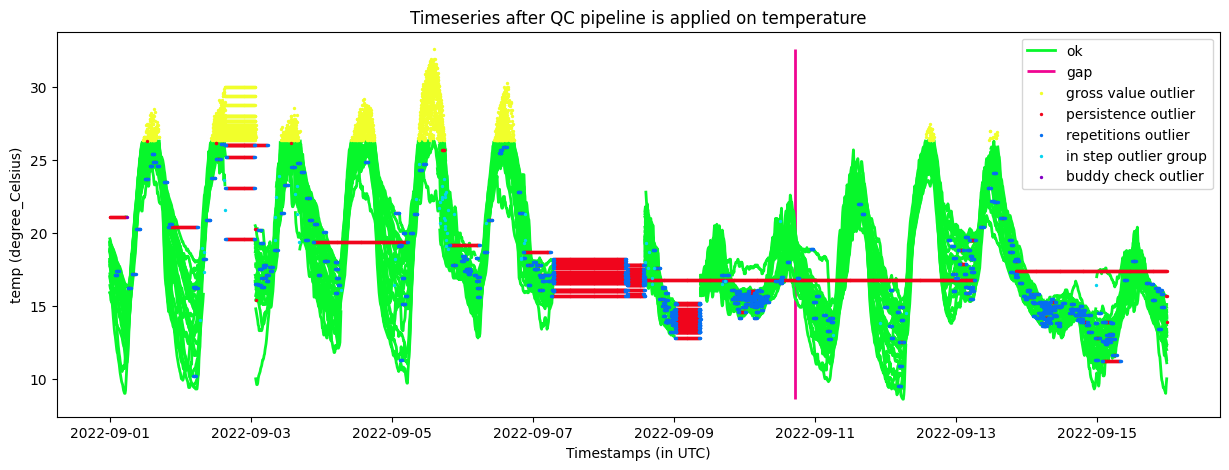

In [8]:
dataset.make_plot(obstype=target,
                  colorby='label',
                  title='Timeseries after QC pipeline is applied on temperature')

If you are interested in the performance of the applied QC, you can use the ``get_qc_stats()`` method to get an overview of the frequency statistics.

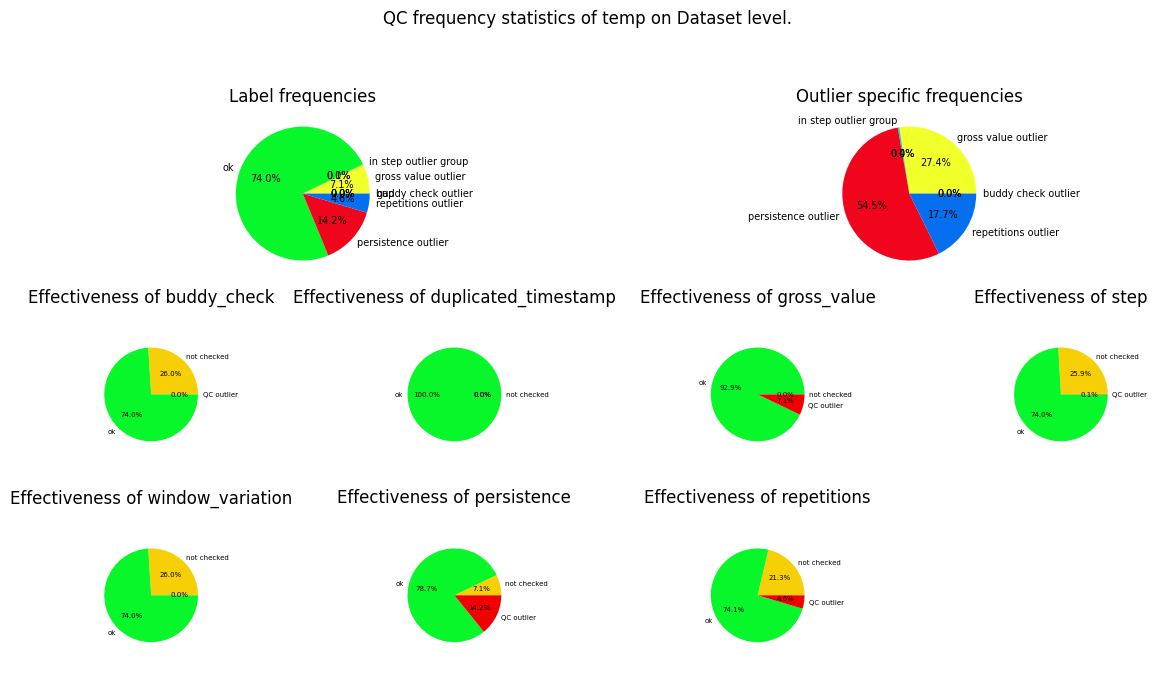

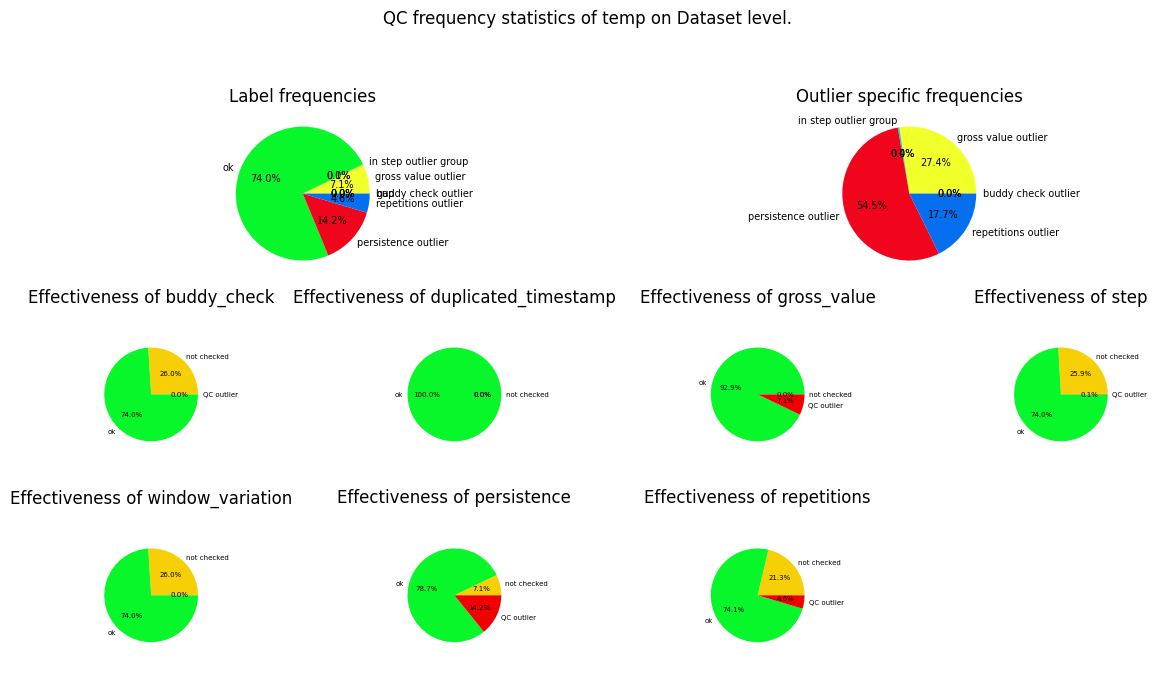

In [9]:
dataset.get_qc_stats(target_obstype=target,
                      make_plot=True)

## Important notes on QC

1. The settings use in this demo example are illustrative.
2. The settings to use depends on:
    * The climate and season for the gross value check
    * The time frequency of your observations, thus apply resample before the QC pipeline
    * The observation type.
